# Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime
import math
import pickle

# Define Functions

In [2]:
def Average(data):
    return sum(data) / len(data)

def convert_bit_lenght(data):        
    a = []
    for element in data:
        native_int = int(element)
        a.append(native_int.bit_length())
    return a

def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

# Read Dataset

In [3]:
data = pd.read_excel('ready_data_pax_bms 1 April - 19 Juli 2023.xlsx', index_col='Unnamed: 0')
data

,DATE,PAX_BMS_T1,PAX_BMS_T2,PAX_BMS_T3
0,2023-04-01 00:00:00,0,8,0
1,2023-04-01 01:00:00,0,0,0
2,2023-04-01 02:00:00,0,0,0
3,2023-04-01 03:00:00,0,0,0
4,2023-04-01 04:00:00,0,0,0
...,...,...,...,...
2635,2023-07-19 19:00:00,73,119,65
2636,2023-07-19 20:00:00,69,92,90
2637,2023-07-19 21:00:00,28,25,47
2638,2023-07-19 22:00:00,2,9,31


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 0 to 2639
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        2640 non-null   datetime64[ns]
 1   PAX_BMS_T1  2640 non-null   int64         
 2   PAX_BMS_T2  2640 non-null   int64         
 3   PAX_BMS_T3  2640 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 103.1 KB


In [5]:
data.describe()

,DATE,PAX_BMS_T1,PAX_BMS_T2,PAX_BMS_T3
count,2640,2640.000000,2640.000000,2640.000000
mean,2023-05-25 23:30:00,36.214773,75.382197,57.459470
min,2023-04-01 00:00:00,0.000000,0.000000,0.000000
25%,2023-04-28 11:45:00,0.000000,4.750000,2.000000
50%,2023-05-25 23:30:00,27.000000,69.000000,57.000000
75%,2023-06-22 11:15:00,65.000000,127.000000,96.000000
max,2023-07-19 23:00:00,194.000000,394.000000,227.000000
std,NaN,36.695872,69.154799,50.794938


# Split data to training, validation and testing

split data with proportion 65% for training data, 30% for validation data and 5% for testing

In [6]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [7]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.65*((len(data))/24)) * 24) 
print(f'jumlah data training: {SPLIT_TIME_TRAIN_REM}')

jumlah data training: 1704


In [8]:
data_train = data[:SPLIT_TIME_TRAIN_REM]['PAX_BMS_T3']
data_train = pd.DataFrame(data_train)
data_train.index = data[:SPLIT_TIME_TRAIN_REM]['DATE']

data_rem = data[SPLIT_TIME_TRAIN_REM:]['PAX_BMS_T3']
data_rem = pd.DataFrame(data_rem)
data_rem.index = data[SPLIT_TIME_TRAIN_REM:]['DATE']

In [9]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.87*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST
print(f'jumlah data validation: {SPLIT_TIME_VAL_TEST}')
print(f'jumlah data validation: {len(data_rem) - SPLIT_TIME_VAL_TEST}')

jumlah data validation: 792
jumlah data validation: 144


In [10]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [11]:
# % of training set
print(f'data training -> {(len(data_train)/len(data)) * 100}%')
print(f'data validation -> {(len(data_val)/len(data)) * 100}%')
print(f'data testing -> {(len(data_test)/len(data)) * 100}%')

data training -> 64.54545454545455%
data validation -> 30.0%
data testing -> 5.454545454545454%


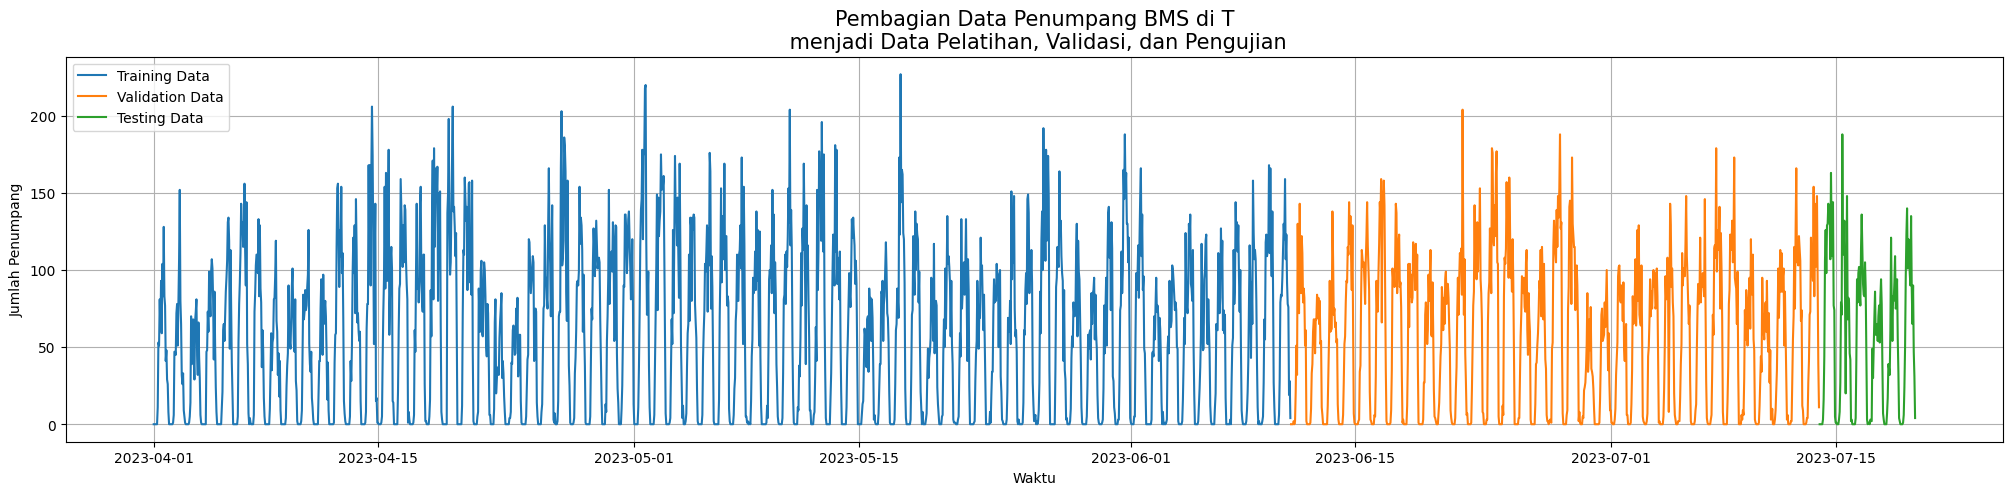

In [12]:
plt.subplots(figsize=(25, 5))
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_train, label='Training Data')
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_val, label='Validation Data')
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_test, label='Testing Data')
plt.xlabel('Waktu'); plt.ylabel('Jumlah Penumpang')
plt.title("Pembagian Data Penumpang BMS di T\n menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 15)
plt.grid()
plt.legend(loc='upper left')

## check sequence data

In [13]:
paxT3 = data["PAX_BMS_T3"].values.reshape(-1, 1)

paxT3_train = data_train.values.reshape(-1, 1)

paxT3_val = data_val.values.reshape(-1, 1)

paxT3_test = data_test.values.reshape(-1, 1)

print(paxT3_train.shape);print(paxT3_val.shape)

(1704, 1)
(792, 1)


In [14]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxT3_train) - n_forecast + 1):
    x_train.append(paxT3_train[i - n_lookback: i])
    y_train.append(paxT3_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 1)
(1657, 24, 1)


In [15]:
print(x_train[0]);print(y_train[0])

[[  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 11]
 [ 53]
 [ 51]
 [ 81]
 [ 61]
 [ 93]
 [ 59]
 [104]
 [ 83]
 [128]
 [ 83]
 [ 77]
 [ 41]
 [ 48]
 [ 29]
 [ 26]
 [  8]
 [  0]]
[[  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  1]
 [  6]
 [ 47]
 [ 47]
 [ 45]
 [ 72]
 [ 78]
 [ 51]
 [ 78]
 [107]
 [152]
 [ 80]
 [ 65]
 [ 32]
 [ 26]
 [ 33]
 [  9]
 [  5]
 [  1]]


In [16]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxT3_val) - n_forecast + 1):
    x_val.append(paxT3_val[i - n_lookback: i])
    y_val.append(paxT3_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 1)
(745, 24, 1)


In [17]:
print(x_val[-1]);print(y_val[-1])

[[  6]
 [  0]
 [  0]
 [  0]
 [  0]
 [  2]
 [  2]
 [ 27]
 [ 55]
 [ 70]
 [115]
 [ 75]
 [125]
 [166]
 [105]
 [111]
 [103]
 [122]
 [114]
 [106]
 [ 67]
 [ 74]
 [ 12]
 [  9]]
[[  0]
 [  0]
 [  0]
 [  0]
 [  1]
 [  4]
 [  4]
 [ 27]
 [ 41]
 [ 71]
 [ 73]
 [121]
 [ 99]
 [101]
 [ 93]
 [154]
 [ 83]
 [143]
 [102]
 [118]
 [148]
 [ 96]
 [ 39]
 [ 11]]


# Scaling / Normalize Data

In [18]:
stdev(convert_bit_lenght(paxT3_train))

2.9794548151666

In [19]:
paxT3_train_scaled = normalize_series(paxT3_train, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))

paxT3_val_scaled = normalize_series(paxT3_val, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))

paxT3_test_scaled = normalize_series(paxT3_test, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))

## Set feature and label period

In [20]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxT3_train_scaled) - n_forecast + 1):
    x_train.append(paxT3_train_scaled[i - n_lookback: i])
    y_train.append(paxT3_train_scaled[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 1)
(1657, 24, 1)


In [21]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxT3_val_scaled) - n_forecast + 1):
    x_val.append(paxT3_val_scaled[i - n_lookback: i])
    y_val.append(paxT3_val_scaled[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 1)
(745, 24, 1)


# Vanilla GRU

## generate model

In [22]:
modelVanillaGRU = Sequential([
        GRU(8, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast)
    ])

modelVanillaGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 8)             264       
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 24)                4632      
                                                                 
Total params: 4,896
Trainable params: 4,896
Non-trainable params: 0
_________________________________________________________________


In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelVanillaGRU.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [24]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v1/VanillaGRU-Model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [25]:
historyVanillaGRU = modelVanillaGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=4, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000
413/415 [============================>.] - ETA: 0s - loss: 14.7231 - mse: 308.9141
Epoch 1: val_mse improved from inf to 280.95740, saving model to ./model v1\VanillaGRU-Model.h5
415/415 [==============================] - 4s 6ms/step - loss: 14.7192 - mse: 308.7357 - val_loss: 14.2014 - val_mse: 280.9574
Epoch 2/1000
404/415 [============================>.] - ETA: 0s - loss: 14.5175 - mse: 301.1211
Epoch 2: val_mse improved from 280.95740 to 273.44662, saving model to ./model v1\VanillaGRU-Model.h5
415/415 [==============================] - 2s 6ms/step - loss: 14.5179 - mse: 301.3526 - val_loss: 13.9811 - val_mse: 273.4466
Epoch 3/1000
413/415 [============================>.] - ETA: 0s - loss: 14.2996 - mse: 293.6040
Epoch 3: val_mse improved from 273.44662 to 265.41699, saving model to ./model v1\VanillaGRU-Model.h5
415/415 [==============================] - 2s 6ms/step - loss: 14.3002 - mse: 293.6465 - val_loss: 13.7377 - val_mse: 265.4170
Epoch 4/1000
407/415 [=========

In [34]:
with open('./model v1/historyVanillaGRU', 'wb') as file_pi:
    pickle.dump(historyVanillaGRU.history, file_pi)

with open('./model v1/historyVanillaGRU', "rb") as file_pi:
    load_historyVanillaGRU = pickle.load(file_pi)

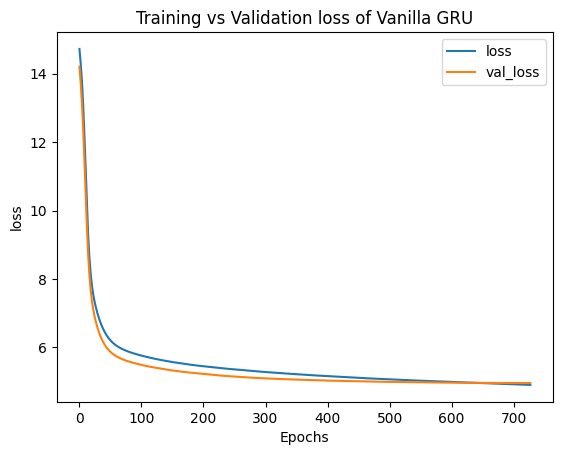

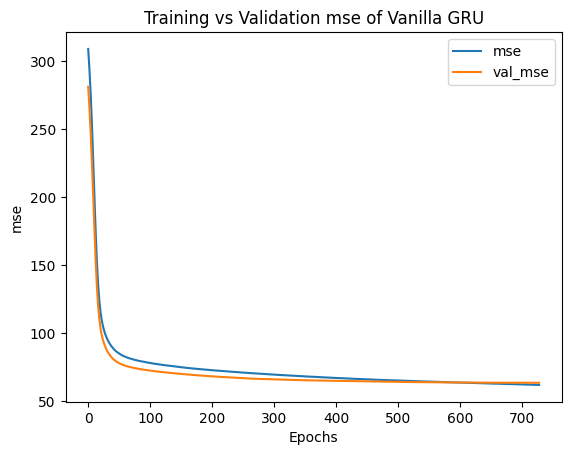

In [35]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyVanillaGRU, "loss")
plot_graphs(historyVanillaGRU, "mse")

## Prediction

### Prediction with training data

In [36]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [37]:
forecast_train_data = model_forecast(modelVanillaGRU, paxT3_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxT3_train_scaled.shape[0]-n_lookback)

1681/1681 [==============================] - 3s 2ms/step
(1681, 24)
(1680,)
1680


In [38]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))
forecast_train_data[:5]

array([-5.16607816, -2.14886244, -1.53674848,  3.16765063,  4.46315996])

In [39]:
actual = np.squeeze(paxT3_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680,)
[0 0 0 0 0]


In [40]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

,Date,Actual,Forecast
0,2023-04-02 00:00:00,0,-5.166078
1,2023-04-02 01:00:00,0,-2.148862
2,2023-04-02 02:00:00,0,-1.536748
3,2023-04-02 03:00:00,0,3.167651
4,2023-04-02 04:00:00,0,4.463160
...,...,...,...
1675,2023-06-10 19:00:00,78,92.661299
1676,2023-06-10 20:00:00,76,91.849993
1677,2023-06-10 21:00:00,19,61.449961
1678,2023-06-10 22:00:00,28,20.230414


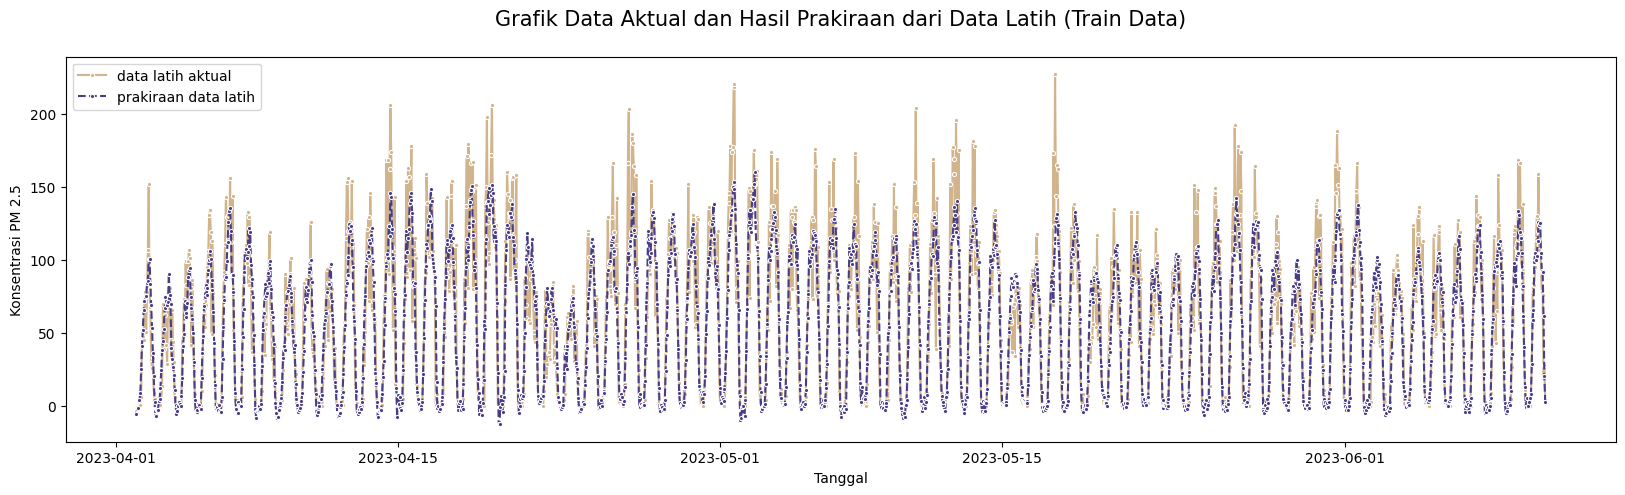

In [41]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [45]:
import plotly.express as px

df = px.data.stocks()
fig = px.line(df_train[-24:], x="Date", y=['Actual', 'Forecast'],
            #   hover_data={"Date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [47]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  21.96
MAE:  14.85
MAPE:  2.6497


## Prediction with validation data

In [61]:
forecast_val_data = model_forecast(modelVanillaGRU, paxT3_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxT3_val_scaled.shape[0]-n_lookback)

769/769 [==============================] - 1s 2ms/step
(769, 24)
(768,)
768


In [62]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))
forecast_val_data[:5]

array([ 3.48238747, -4.72060783, -2.74329384, -0.3208123 , -1.36816414])

In [63]:
actual = np.squeeze(paxT3_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768,)
[0 0 0 0 0]


In [64]:
len(data_val[-forecast_val_data.shape[0]:])

768

In [65]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

,Date,Actual,Forecast
0,2023-06-12 00:00:00,0,3.482387
1,2023-06-12 01:00:00,0,-4.720608
2,2023-06-12 02:00:00,0,-2.743294
3,2023-06-12 03:00:00,0,-0.320812
4,2023-06-12 04:00:00,0,-1.368164
...,...,...,...
763,2023-07-13 19:00:00,118,97.371918
764,2023-07-13 20:00:00,148,83.325880
765,2023-07-13 21:00:00,96,73.217884
766,2023-07-13 22:00:00,39,46.192095


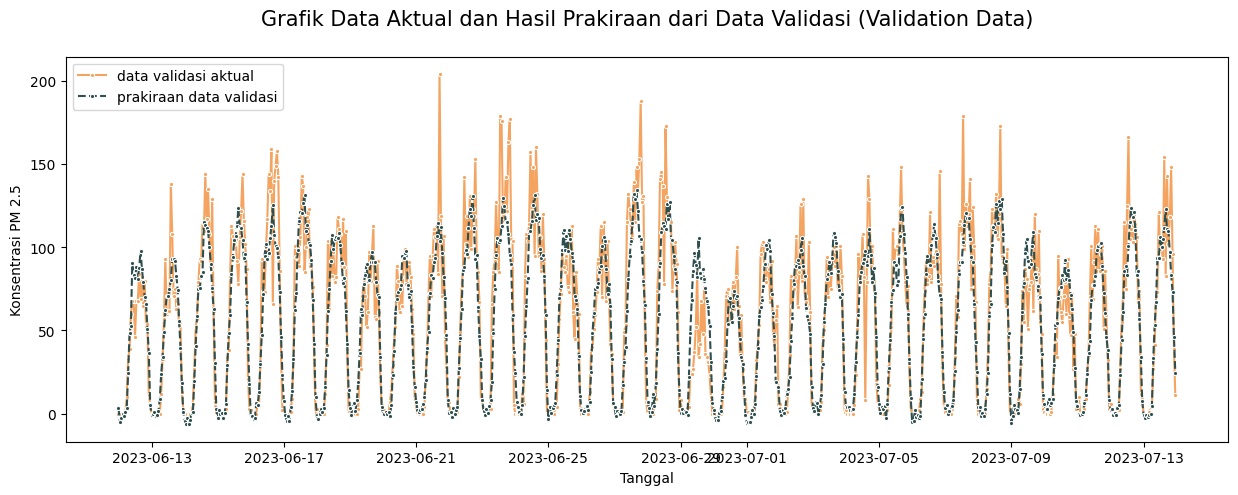

In [66]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [67]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  20.62
MAE:  14.16
MAPE:  0.763


## Prediction with test data

In [68]:
forecast_test_data = model_forecast(modelVanillaGRU, paxT3_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxT3_test_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 24ms/step

121/121 [==============================] - 0s 2ms/step
(121, 24)
(120,)
120


In [69]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))
forecast_test_data[:5]

array([ 7.36830478, -5.78071255, -0.23553891,  9.52348285,  0.64791828])

In [70]:
actual = np.squeeze(paxT3_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120,)
[1 1 0 0 0]


In [71]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

,Date,Actual,Forecast
0,2023-07-15 00:00:00,1,7.368305
1,2023-07-15 01:00:00,1,-5.780713
2,2023-07-15 02:00:00,0,-0.235539
3,2023-07-15 03:00:00,0,9.523483
4,2023-07-15 04:00:00,0,0.647918
...,...,...,...
115,2023-07-19 19:00:00,65,86.097210
116,2023-07-19 20:00:00,90,72.976842
117,2023-07-19 21:00:00,47,58.415253
118,2023-07-19 22:00:00,31,30.279771


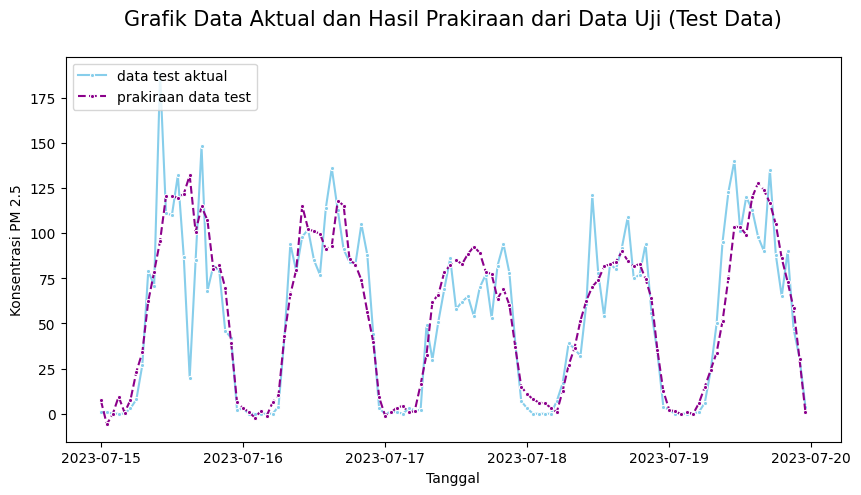

In [72]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [73]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  21.69
MAE:  13.78
MAPE:  0.5125


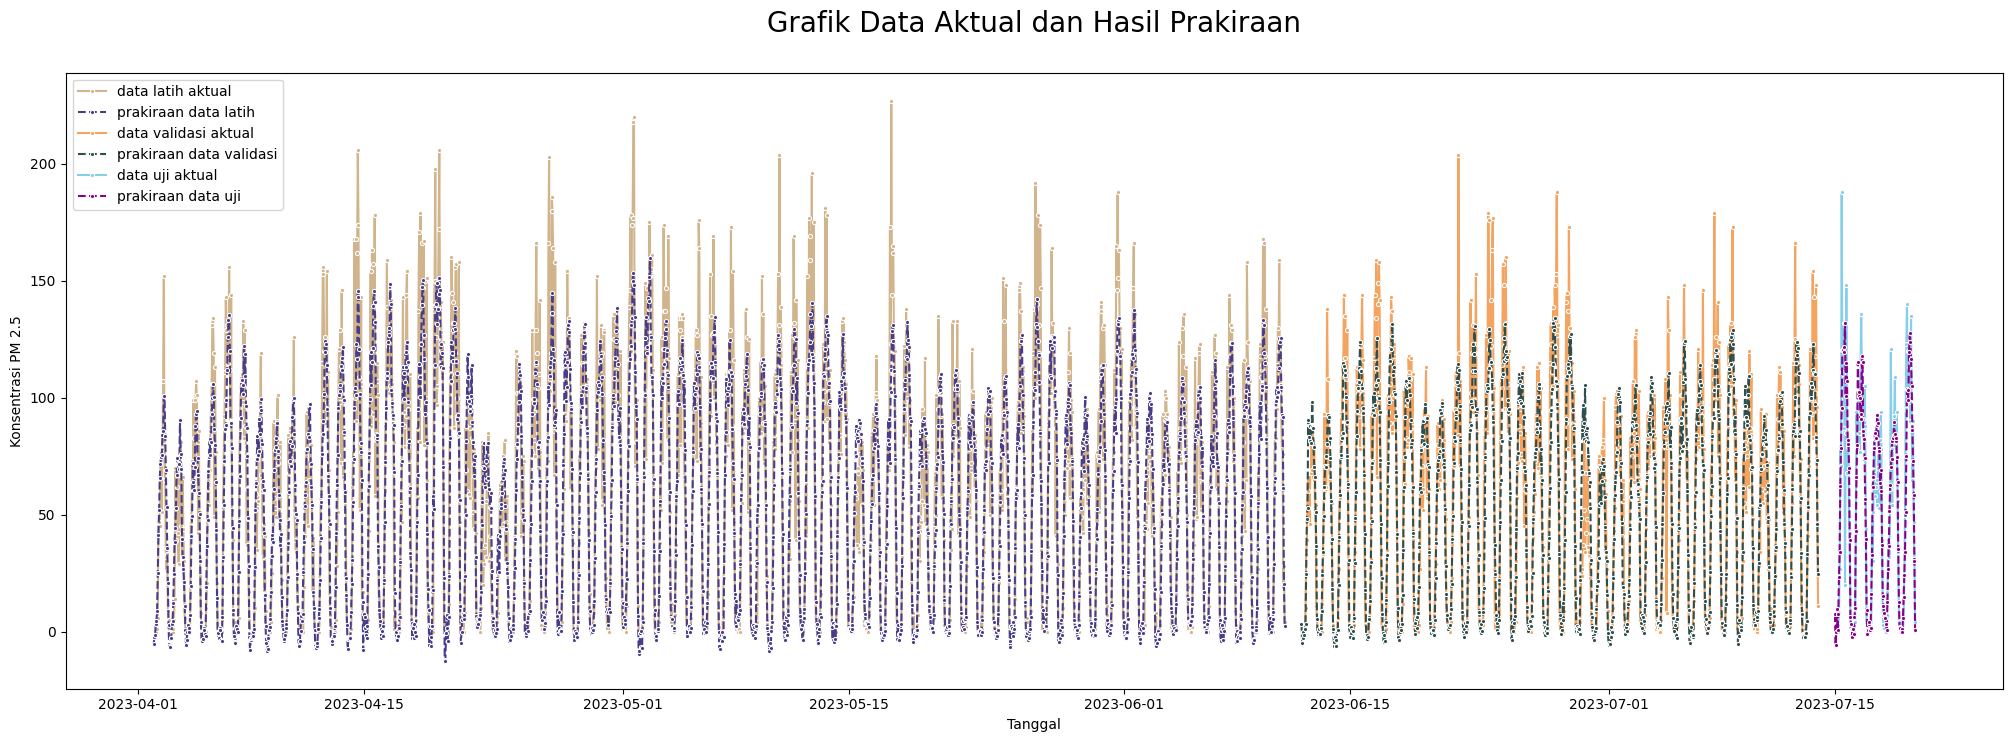

In [74]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')